# ANLP Assessed Coursework 1

For this assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

Marking guidelines are provided as a separate document.

In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.

In [1]:
candidateno=213120 #this MUST be updated to your candidate number so that you get a unique data sample

In [1]:
#preliminary imports
import sys
sys.path.append(r'\\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources')
sys.path.append(r'/Users/juliewe/resources')

import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.tokenize import word_tokenize

from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
import random
from nltk.corpus import stopwords

Sussex NLTK root directory is \\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources


# Question 1: Naive Bayes Classification (25 marks)

In this question, you will be considering how a Naive Bayes classifier can be applied to the task of deciding whether sentences are relevant or not relevant to the kitchen domain.

The code below will generate for you two small unique sets of sentences, which you should refer to in your answer to this question.   This question will be marked on the quality of your explanations rather than the quality of your code.

In [23]:
topics=["book","kitchen","dvd","electronics"]
samplesize=20
stop=stopwords.words('english')

trainingsentences=[]
testsentences=[]
cr = AmazonReviewCorpusReader()

for topic in topics:
    random.seed(candidateno)
    if topic == "kitchen":
        key="kitchen"
    else:
        key="not-kitchen"
    topicsentences=[]
    while len(topicsentences)<10:
        topicsentences=[({token.lower():True for token in doc if token.lower() not in stop and token.isalpha()},key) for doc in cr.category(topic).sample_sents(samplesize=samplesize) if len(doc)>0]
    testsentences+=topicsentences[0:3]
    trainingsentences+=topicsentences[3:]

random.shuffle(trainingsentences)
mixup=testsentences[:4]+testsentences[5:]
random.shuffle(mixup)
testsentences=[testsentences[4]]+mixup
print("Number of training sentences is {}.  Number of testing sentences is {}".format(len(trainingsentences),len(testsentences)))


Number of training sentences is 59.  Number of testing sentences is 12


In [11]:
#print(trainingsentences,'\n')
#print(testsentences)

not-kitchen


## Question 1a)

a) With reference to the sentences generated above, **explain** how a Naive Bayes classifer would be trained to carry out the task of deciding whether sentences are relevant to the kitchen domain.  You do **not** need to build or train a classifier.  However, you should explain the relevant probabilities with reference to examples taken from your samples of sentences.  \[10 marks\]

### Naive Bayes ###

As with all machine-learning based approaches to document classification, the model of choice requires some form of training in order to perform as desired. Naive Bayes refers to a family of probabilistic classifier algorithms that take advantage of Bayes Theorem in conjunction with probability theory to predict the most likely class $c$ to which a sentence $s$ belongs. In our case, the two classes in question are `kitchen` or `not-kitchen`, referring to what the sentence holds relevance to. At a high level, this is done as a function of two parameters, the **Prior Probabilities** of a class, and the **Conditional Probabilities** of each feature's presence within each class. In our context, training this Naive Bayes classifier is in essecne the process of estimating these two probabilities based on our training data. It is important to note that this is an example of supervised learning, and so each sentence in our training data is labelled with its true class. 

Pre-processing is crucial with a classifier such as this, the precurser to that is to perform feature extraction. In this domain that is to represent every sentence as a **Bag-of-Words** with each word constituting a feature $f$. This means the order and grammatical structure is ignored, and so word context is lost. 

With reference to our generated sentences above, in order to classify any given sentence $s$, we must evaluate the greater of these two probabilities:

$$P(\,\mbox{kitchen}\,|\,s) \qquad\qquad \mbox{versus} \qquad\qquad P(\,\mbox{not-kitchen}\,|\,s)$$


Note that $P(A|B)$ denotes the probability of $A$, given that $B$ is true. So $P(\,\mbox{kitchen}\,|\,s)$ gives the probability of membership to the class `kitchen`, given the sentence $s$. For example, if $s$ were the sentence "I opened the oven", the probabilites that would need evaluating to decide its class would be as follows:

$$P(\,\mbox{kitchen}\,|\,\mbox{"I opened the oven"}) \qquad\qquad \mbox{versus} \qquad\qquad P(\,\mbox{not-kitchen}\,|\,\mbox{"I opened the oven"})$$

As per Bayes' rule:

$$P(A|B) = \frac{P(B|A)\cdot P(A)}{P(B)}$$

If we apply this to our comparison, we are left with this:

$$\frac{P(\,s\,|\,\mbox{kitchen}\,)\cdot P(\,\mbox{kitchen}\,)}{p(s)} \qquad\qquad \mbox{versus} \qquad\qquad \frac{P(\,s\,|\,\mbox{not-kitchen}\,)\cdot P(\,\mbox{not-kitchen}\,)}{p(s)}$$

Since we are evaluating the same sentence $s$ on each side, we can then multiply both sides through by the denominator, to remove them both without it carrying any effect on which class maximises the probability, leaving us with the following: 

$$P(\,s\,|\,\mbox{kitchen}\,)\cdot P(\,\mbox{kitchen}\,) \qquad\qquad \mbox{versus} \qquad\qquad P(\,s\,|\,\mbox{not-kitchen}\,)\cdot P(\,\mbox{not-kitchen}\,)$$


Each side is now made up of the two parameters we mentioned earlier, in the form:

$$Conditional Probability \times Prior Probability$$

### Prior Probabilities ###

The class priors are the probabilities that any randomly selected sentence belongs to the class in question, in our case that's $P(\,\mbox{kitchen}\,)$ and $P(\,\mbox{not-kitchen}\,)$ for each class respectively. The classifier can use the exact prior probabilities of each class in the training data to estimate what they will be in any testing data of the same domain. Below I have implemented a function `prior_probabilities` which takes the labelled training data as input, and produces a dictionary mapping each class to its prior probability, based on the given training data.

In [4]:
def prior_probabilities(trainingData):
    return{
        class_name:
        #Calulcates total amount of features belonging to a sentence of given class
        #Implemented add-one smoothing in case a class had no data
        sum(len(current_sent)+1 for current_sent, current_class_name in trainingData if current_class_name==class_name)
        
        #Divides by the total to express ratio as percentage
        /(sum([len(sentences) for sentences, class_name in trainingData])+len(trainingData))
        
        #repeats for each class
        for sentences, class_name in trainingData
    }

print("Training data Prior Probabilities: ", prior_probabilities(trainingsentences))
#print("Testing dara Prior Probabilities: ",prior_probabilities(testsentences))

Training data Prior Probabilities:  {'not-kitchen': 0.7505330490405118, 'kitchen': 0.24946695095948826}


The classifier will now have a bias towards sentences being of the class `not-kitchen`, as they are more common from what it has seen:

- $P(\mbox{kitchen})$, The probability that a sentnece belongs to class `kitchen` is $0.249..$. (to 3 s.f) 


- $P(\mbox{not-kitchen})$, The probability that a sentnece belongs to class `not-kitchen` is $0.751.. $. (to 3 s.f) 

It's important to note that priors should only be taken of the training portion of the labelled training data, and not the testing portion. This would lead to the overfitting of your model.

### Conditional Probabilities ###

In order to estimate the conditional probabilities, $P(\,s\,|\,\mbox{kitchen}\,)$ and $P(\,s\,|\,\mbox{not-kitchen}\,)$, the naive assumption is made that all the features (distinct words appearing in the sentence) are independant. That is to say that the features bear no relationship or impact to eachothers likelihoods of appearing in a certain class. With independant events, the following holds true:
$P(A|B) = P(A)\cdot P(B)$

Thereofore, going back to our earlier example where sentence $s$ = "I opened the oven", it can be said that:

\begin{eqnarray*}
P(\,\mbox{"I opened the oven"}\,|\,\mbox{kitchen}\,) &=& P(\{\mbox{"I"},\mbox{"opened"},\mbox{"the"},\mbox{"oven"}\,|\,\mbox{kitchen}\,)\\
&=& P(\,\mbox{"I"}\,|\,\mbox{kitchen}\,)\cdot P(\mbox{"opened"}\,|\,\mbox{kitchen}\,)\cdot P(\mbox{"the"}\,|\,\mbox{kitchen}\,)\cdot
P(\mbox{"oven"}\,|\,\mbox{kitchen}\,)
\end{eqnarray*}

Given a sufficient amount of training data, we should be able to estimate each of those probabilities for every feature within our bag-of-words. 

\begin{eqnarray*}
P(\,s\,|\,c\,) &=& P(\,\{f_1,\ldots,f_n\}\,|\,c\,)\\
&=& \prod_{i=1}^n P(\,f_i\,|\,c\,)
\end{eqnarray*}


To calculate the conditional probability $P(s|c)$ for a sentence $s$ and class $c$,we are multiplying together $n$ conditional probabilities, where $n$ is the number of features in $s$. In longer sentences this could lead to underflow, due to multuplying large amounts of small numbers together. This is where the importance of pre processing comes in. Stop-word removal is a very necessary form of this, as it greatly reduces the amount of features within the bag-of-words (and therefore multiplications being carried out), all of which hold little to no value for determining class.

Additionally, if a single feature appeared in the testing data that hadn't been seen during training, it would be given a probability of 0 of belonging to either class, resulting in a nullified classification. I will be negating this by implementing add-one smoothing.

In [108]:
#Creates a set of all features present in the training data
def seen_vocab(trainData):
    return {feature for sentence, label in trainData for feature in sentence}

#Creates a dictionary of all features and their conditional probabilities given a class
def conditional_probs(trainData):
    counts_per_class={}
    total_counts={}

    Freqs={} #Frequency counts of each feature for each class
    for sentence, label in trainData:
        if Freqs.get(label,None)==None:
            Freqs[label]={}
        for word in sentence.keys():
            Freqs[label][word]=Freqs[label].get(word,0)+1 #Add-one smoothing          
    for word in seen_vocab(trainData):
        for label in Freqs:
            Freqs[label][word]=Freqs[label].get(word,0)+1 #Add-one smoothing
    #print(Freqs)
    
    conditionalProbs={} #Dictionary mapping all class features to their conditional probabilites with respect to each class
    for label, data in Freqs.items():
        if conditionalProbs.get(label,None)==None:
            conditionalProbs[label]={}
        for word in data:
            conditionalProbs[label][word]=Freqs[label][word]/sum(Freqs[label].values())
    return conditionalProbs


conditional_probs(trainingsentences)
#seen_vocab(trainingsentences)

{'not-kitchen': {'pleasantly': 0.0029895366218236174,
  'surprised': 0.0029895366218236174,
  'funny': 0.0029895366218236174,
  'inspirational': 0.0029895366218236174,
  'one': 0.004484304932735426,
  'meeting': 0.0029895366218236174,
  'nikita': 0.0029895366218236174,
  'k': 0.0029895366218236174,
  'political': 0.0029895366218236174,
  'officers': 0.0029895366218236174,
  'wets': 0.0029895366218236174,
  'pants': 0.0029895366218236174,
  'another': 0.0029895366218236174,
  'ed': 0.0029895366218236174,
  'harris': 0.0029895366218236174,
  'konig': 0.0029895366218236174,
  'oscar': 0.0029895366218236174,
  'worthy': 0.0029895366218236174,
  'performance': 0.0029895366218236174,
  'also': 0.0029895366218236174,
  'featurette': 0.0029895366218236174,
  'featuring': 0.0029895366218236174,
  'zsigmond': 0.0029895366218236174,
  'even': 0.005979073243647235,
  'fascinating': 0.0029895366218236174,
  'discusses': 0.0029895366218236174,
  'methods': 0.0029895366218236174,
  'woman': 0.0029895

Now that both the conditional and prior probabilities have been estimated based on the training data, the model is ready to be tested on the testing portion of the labelled data, to assess its effectiveness before being used on unlabelled data.

## Question 1b)

b) With reference to the sentences generated above, **explain** how a trained Naive Bayes classifier would assign a class to a sentence. \[5 marks\]

Using the estimates for the **conditional probability** of each feature's presence in a sentence $s$, given $s$' membership to a certain class, $\prod_{i=1}^n P(\,f_i\,|\,c\,)$, multiplied by the **prior probability** estimates of that same class $P(c)$, a Naive Bayes classifier can calculate the most probable class of a sentence given all of its $n$ features $f_i^n$. This can be expressed as:

$$argmax_c P(c|f_i^n) = argmax_c \prod_{i=1}^n P(\,f_i\,|\,c\,) \cdot P(c)$$



In [107]:
print(testsentences[8])

({'best': True, 'movie': True, 'visual': True, 'experience': True}, 'not-kitchen')


To use one of our test sentences as an example, we can see that the set of features present, $f_i^4$, contains 'best', 'movie', 'visual' and 'experience'. Let's first consider the class `kitchen`. The classifier would use the above formula to calculate the probability of the sentence belonging to the class in question.

$$P(\mbox{kitchen}|f_i^4) = P(\mbox{'best'}|\mbox{kitchen}) \cdot P(\mbox{'movie'}|\mbox{kitchen}) \cdot P(\mbox{'visual'}|\mbox{kitchen})\cdot P(\mbox{'experience'}|\mbox{kitchen}) \cdot P(\mbox{kitchen})$$

The same calculation would then be carried out with respect to the other class, `not-kitchen`, and the sentence would be assigned to the class assiciated with the maximum value between:
$$P(\mbox{kitchen}|f_i^4) \qquad\qquad \mbox{versus} \qquad\qquad P(\mbox{not-kitchen}|f_i^4)$$

It's easy to see how underflow errors would be commonplace without stop word removal, as even with only 4 features, we are likely dealing with numbers somewhere in the approximate range $x \times 10^{-10|-15}$. With larger documents, we can negate this by summing the logs, as the evaluation will not be changed provided logs are taken of all probabilities:

\begin{eqnarray*}
&=& \sum_{i=1}^n \log(P(\,c\,|\,f_i^n\,))
\end{eqnarray*}


The need for smoothing is also made clear, as half of the features ('visual' and 'experience') don't appear in the training data. If a sentence were to contain only words that were equally likely to appear in either class, the classification would depend entirely on the prior probabilities.

## Question 1c)

c)  The labels assigned by a Naive Bayes classifier to the sentences contained in the variable `testsentences` above are \['kitchen','not-kitchen','not-kitchen','not-kitchen','kitchen','not-kitchen','kitchen','not-kitchen','not-kitchen','not-kitchen','kitchen','not-kitchen'\].  Using this example to illustrate your answer, **explain** how each of the performance metrics of *accuracy*, *precision*, *recall* and *F1-score* are calculated.  Which of these metrics would you use to choose between classification models in this example?  **Justify your answer**. \[10 marks\]


In [13]:
for sentence in testsentences:
    print(sentence[1])

kitchen
not-kitchen
not-kitchen
not-kitchen
not-kitchen
not-kitchen
not-kitchen
kitchen
not-kitchen
not-kitchen
not-kitchen
kitchen


Above we can see the true classes of each of the classifier's predictions, with this information we can create the confusion matrix below:

|-----| Predicted `kitchen`   | predicted `not-kitchen`   |
|------|------|------|
| Actual `kitchen`  | 1 True Positive |2 False Negative|
|Actual `not-kitchen`|3 False Positive |6 True Negative|

The accuracy of a classifier is defined as follows:

$$Accuracy =\dfrac{|\{i|\mbox{prediction}(i)=\mbox{label}(i)\}|}{|\{i\}|} = \dfrac{True Positives + True Negatives}{Total Predictions}$$ 

Therefore in our case:

$$Accuracy = \dfrac{1 + 6}{12} = \dfrac{7}{12} = 0.58333..$$ 

A high degree of accuracy is of course desirable as it is inversely proportional to the error rate ($Accuracy + Error Rate = 1$). The limitation of this metric is that it can be misleading as the accuracy may average out at 60% for example, but the accuracy on any individiual sentence could be greater or lower depending on its true class, one of the more marginal class is more likely to vary.

Precision can be described as the proportion of positive predictions that are correct, and is denoted by:


$$Precision=\frac{True Positives}{True Positives + False Positives}$$

And therefore in our case:

$$Precision=\frac{1}{1 + 3} = 0.25$$

Another metric to consider is the Recall, which is the proportion of actual positives which are predicted correctly, 

$$Recall=\frac{True Positives}{True Positives + False Negatives} = \frac{1}{1 + 2} = 0.333..$$

A high precision and recall is indicitative of a good classifier, however usually there is a trade-off between the two. This is why we have our final metric, F1-Score:

$$F1=\frac{2 \times Precision \times Recall}{Precision + Recall}$$

In our case that would equate to:

$$F1=\frac{2 \times 1/4 \times 1/3}{1/4 + 1/3} = \frac{2}{7} = 0.2857...$$

F1 score combines precision and recall to give a harmonic mean of the two. It takes a value closer to the lower of the two values, giving a more realistic and well rounded representation of how well the classifier is performing than other metrics. This is why it would be my chosen metric.

## Question 2: Training Data for Sentiment Analysis (25 marks)
The objective of this question is to investigate the extent to which performance of a Naive Bayes classifier is affected by the quantity and quality of the training data.  Does more training data mean better performance?  Is performance degraded if we train on one domain and test on another domain?  For example, suppose we train a sentiment classifier on book reviews and then test that classifier on a collection of dvd reviews. Does it perform as well as it would when trained on dvd reviews?

The code below is included to enable you to get pre-formatted training and test data for a given category (evenly split between positive and negative reviews).  In this question, there are marks available for the quality of your programming, your experimental design and your interpretation of results.


In [276]:
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(category,ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given category and ratio, pre-formatted for use with NB classifier
    :param category: category of review corpus, one of ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    reader=AmazonReviewCorpusReader().category(category)
    random.seed(candidateno)
    pos_train, pos_test = split_data(reader.positive().documents(),ratio=ratio)
    neg_train, neg_test = split_data(reader.negative().documents(),ratio=ratio)
    train_data=[(feature_extract(review),'P')for review in pos_train]+[(feature_extract(review),'N') for review in neg_train]
    test_data=[(feature_extract(review),'P')for review in pos_test]+[(feature_extract(review),'N') for review in neg_test]
    return train_data,test_data

### Question 2a) ###

a) By varying the amount of training data used, **investigate** the impact of the amount of training data used on the accuracy of a Naive Bayes classifier for each of the four domains: *dvd*, *book*, *kitchen* and *electronics*.  You should use the NaiveBayesClassifier from the `nltk.classify` library.  You should also use a table and an appropriate graph(s) to display your results.  Make sure you **discuss** your results and conclusions. \[8 marks\]

In [275]:
def reduce_training_data(trainingData):
    """
    Creates 10 reduced training data sets of incrementally varying sizes
    :params: trainingData - List of labelled training data
    :return: reducedData - List of Lists, 
                            each sublist is a reduced form of the input.
    """
    reducedData = []
    increments = [0.9,0.9,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
    for i in range(10):
        reducedData.append(trainingData[int(len(trainingData) * increments[i]) : int(len(trainingData))])
    return reducedData

#testsentences
#reduce_training_data(testsentences)

The code above defines a function which slices the training data in accordance with the chosen increments to allow me to investigate classifier performance across the full range of available training data sizes

In [279]:
trainData, testData = [],[]
categories = ["kitchen", "dvd", "book", "electronics"]
increments = [0.9,0.9,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
results = {}

#Loops through to get all required data for each category 
for category in categories:
    trainData.append(get_training_test_data(category)[0])
    testData.append(get_training_test_data(category)[1])

    
#loop to train and test classifier on each domain, at every training data size interval    
for x in range(len(categories)):
    result = {}
    sliceIndex = 0
    for slicedSet in reduce_training_data(trainData[x]):
        classifier = nltk.NaiveBayesClassifier.train(slicedSet)
        result[sliceIndex] = round(nltk.classify.accuracy(classifier, testData[x]),4)
        sliceIndex+= 1
    results[x] = (result.copy())

The nested-looping structure above trains and tests a classifier on its own domain, at every training data interval size, then repeats this 4 times - one for each domain. The resulting dictionary is plotted by the code below.

,Kitchen,DVD,Book,Electronics
10%,0.5000,0.5000,0.5000,0.5000
20%,0.5000,0.5000,0.5000,0.5000
30%,0.5000,0.5000,0.5000,0.5000
40%,0.5000,0.5000,0.5000,0.5000
50%,0.5000,0.5000,0.5000,0.5000
60%,0.6933,0.7183,0.6567,0.7133
70%,0.8000,0.7850,0.7017,0.7467
80%,0.8167,0.7467,0.7067,0.7817
90%,0.8233,0.7583,0.7450,0.7917
100%,0.8267,0.7483,0.7467,0.7967


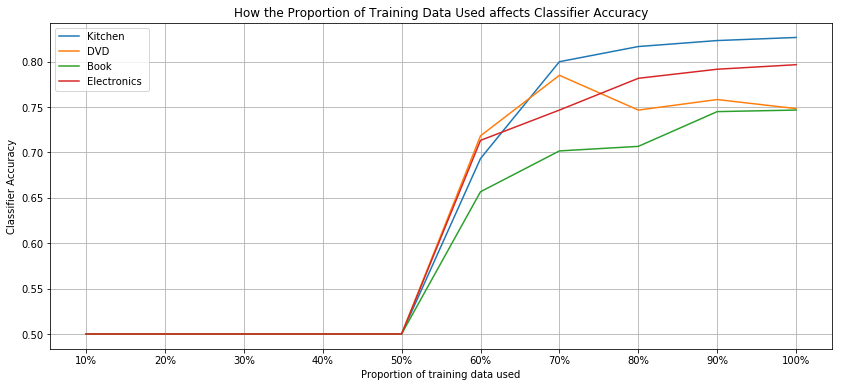

In [280]:
#Disaplays results in a pandas dataframe
accuraciesDF = pd.DataFrame(results)
accuraciesDF.index = ['10%', '20%','30%','40%','50%','60%','70%','80%','90%','100%']
accuraciesDF.columns = ['Kitchen ', 'DVD ', 'Book ', 'Electronics ']
display(accuraciesDF)

#Visualises results as line graph
accuraciesDF.plot(kind='line', figsize=(14,6),title=("How the Proportion of Training Data Used affects Classifier Accuracy"))
plt.grid()
plt.xticks([0,1,2,3,4,5,6,7,8,9],accuraciesDF.index)
plt.xlabel("Proportion of training data used")
plt.ylabel("Classifier Accuracy")
plt.show()


Statistically, you would expect a binary classifier with no training to be correct approximately 50% of the time - our classifier doesn't perform to a level beyond this when trained on any less than half of the training data. After further investigation I suspect the unusually high level of consistency within that range to be attributed to the method in which I reduced the training data set - leading to a discrepancy between the prior probabilities in the relevant training and testing sets. 

Once we begin to move past the 50% mark, the accuracies of the classifiers initially improve drastically before beginning to taper off. The trend of all four categories seems to be somewhat logarithmic, which comes at no surprise when we consider that the classifier functions probabilistically. Although all categories see significant improvement with more training data, I would like to draw attention to the 2 worst performing categories - DVDs and Books. At no point did any category aside from DVD see any reduction in performance, whilst books only saw a fairly negligable increase in the same interval. I anticipate the reason our classifier hasn't performed as well on these two categories to be because these are the two with the most broad vocabulary domain. The subject of a book or DVD is not limited, and thus neither are the words used within them, or to describe them. On the other hand, kitchen (our best performing catergory), has a much more restricted domain of words that would typically be associated with it.

b) For each possible combination of source and target domain, **evaluate** the accuracy of a Naive Bayes classifier trained on the source domain and tested on the target domain.  There are four domains so there are 16 possible combinations you should consider.  You should use a table and an appropriate graph(s) to display your results.  Make sure you **discuss** your results and conclusions. \[8 marks\]

In [8]:
categories = ["kitchen", "dvd", "book", "electronics"]
trainData, testData = [],[]
results, accuracy = {},{}
index = 0 #For storing results

#Iterates through each category, appending the corresponding training and testing data
for topic in categories:
    trainData.append(get_training_test_data(topic)[0])
    testData.append(get_training_test_data(topic)[1])
    

#Trains a classifier on each category's training data
for domain in trainData:
    classifier = nltk.NaiveBayesClassifier.train(domain)
    
    #Tests each trained classifier on all 4 domains, resulting in all 16 (4 x 4) combinations
    for x in range(4):
        accuracy[x] = round(nltk.classify.accuracy(classifier, testData[x]),4)
    results[index] = (accuracy.copy()) #Logs results
    index += 1 #Increment result storage location
    accuracy.clear()

The code above didn't require an awful lot of adaptation, the key functionality is still provided by a nested loop - the inner of which, again,  varies the training data. However this time it varies the domain of it as opposed to the size.

In [145]:
print(results)

{0: {0: 0.8267, 1: 0.7117, 2: 0.6783, 3: 0.7533}, 1: {0: 0.675, 1: 0.7483, 2: 0.7067, 3: 0.6583}, 2: {0: 0.6333, 1: 0.6933, 2: 0.7467, 3: 0.6117}, 3: {0: 0.8, 1: 0.6467, 2: 0.63, 3: 0.7967}}


,Kitchen Test Data,DVD Test Data,Book Test Data,Electronics Test Data
Kitchen,0.8267,0.6750,0.6333,0.8000
DVD,0.7117,0.7483,0.6933,0.6467
Book,0.6783,0.7067,0.7467,0.6300
Electronics,0.7533,0.6583,0.6117,0.7967


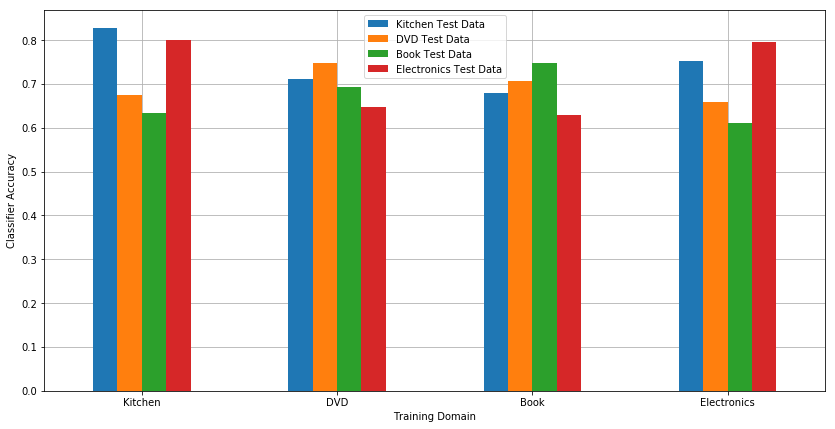

In [9]:
#Create pandas dataframe of results
df = pd.DataFrame(results)
df.index = ['Kitchen', 'DVD', 'Book', 'Electronics']
df.columns = ['Kitchen Test Data', 'DVD Test Data', 'Book Test Data', 'Electronics Test Data']
display(df)

#Plot bar chart to visualise dataframe
df.plot(kind='bar', figsize=(14,7), rot=0, zorder=5)
plt.grid(zorder=0)
plt.xlabel("Training Domain")
plt.ylabel("Classifier Accuracy")
plt.show()

As predicted, the classifier that had been trained on the corresponding data set to that upon which it was tested outperformed any other, and this remained true for all categories. These findings do demonstrate the domain dependance existent within supervised learning models - domain adaptation continues to be a hurdle within the field that one must be conscious of. 

Particular results that I deem worthy of discussion include the impressive performance of both the Kitchen and Electronics trained classifiers' performance on their non-respective test data sets. Whilst the average domain gap lead to a **9.64%** (to 3 s.f) drop in performance relative to their home domain, or **14.28%** (to 3 s.f) relative to the locally trained classifier, that which was trained on Electronics actually improved marginally (by 0.4%) when tested on the kitchen domain. It must be made clear that it still did not outperform the locally trained classifier, however the similarity in their non-native performances illustrates that some domain gaps are significantly narrower than others. In this particular case, I anticipate the tight relationship between the two domains to be as a result of the overlap between the vocabulary used in the context of electronics and kitchen appliances.  

c) Adapt your code so that you can build and use a training set built from multiple categories.  Now **investigate** how having a mixture of source domains affects the accuracy of the Naive Bayes classifier on the target domain.  Make sure you control for or consider how much any improvements are due to the quantity of the training data. \[9 marks\]

In [112]:
def popTrainByRatio(categoryCombos):
    """
    Fetches a portion of training data for the given category combination, ensuring to preserve the 0.7 ratio.
    :params: categoryCombos - List of a combination of categories, the domains of which will make up a unique set of training data
    :return: trainData      - Equally sized set of training data, regardless of amount of source domains                       
    """
    trainData = []
    for combo in categoryCombos:
        if (len(categoryCombos) == 2):
            trainData += get_training_test_data(combo, 0.35)[0]
        if (len(categoryCombos) == 3):
            trainData += get_training_test_data(combo, 0.2334)[0]
        if (len(categoryCombos) == 4):
            trainData += get_training_test_data(combo, 0.175)[0]
    return trainData

In [146]:
categoryDoubles, categoryTriples, categoryCombos = [],[],[]
trainDoubles, trainTriples, trainQuad, totalTrain = [],[],[],[]
testData = []


#All remaining combinations of training-data mixes
categories = ["kitchen", "dvd", "book", "electronics"]
categoryDoubles_1 = ["kitchen", "dvd"]
categoryDoubles_2 = ["kitchen", "book"]
categoryDoubles_3 = ["kitchen", "electronics"]
categoryDoubles_4 = ["dvd", "book"]
categoryDoubles_5 = ["dvd", "electronics"]
categoryDoubles_6 = ["book", "electronics"]
categoryTriples_1 = ["kitchen", "dvd", "book"]
categoryTriples_2 = ["kitchen", "dvd", "electronics"]
categoryTriples_3 = ["electronics", "dvd", "book"]
categoryTriples_4 = ["kitchen", "book", "electronics"]
#Formats data in to one list of lists
categoryCombos.extend([categoryDoubles_1, categoryDoubles_2, categoryDoubles_3, categoryDoubles_4, categoryDoubles_5, categoryDoubles_6])
categoryCombos.extend([categoryTriples_1, categoryTriples_2, categoryTriples_3, categoryTriples_4])
categoryCombos.extend([categories])

#Populates testing data,ordered by category to allow the later use of individual domains
for category in categories:
    testData.append(get_training_test_data(category)[1])

#Populates several training data sets, each spanning a different amount of domains
for comboGroup in categoryCombos:
    if len(comboGroup) == 2:
        trainDoubles.append(popTrainByRatio(comboGroup))
    if len(comboGroup) == 3:
        trainTriples.append(popTrainByRatio(comboGroup))
    if len(comboGroup) == 4:
        trainQuad.append(popTrainByRatio(comboGroup))
totalTrain.extend([trainDoubles, trainTriples, trainQuad])

In [147]:
indvComboAccuracies = [] 
domainSpanAccuracies = {}
allAccuracies = {}
docIndex = 0 
domainIndex = 0 

for testDomain in testData: #Iterates 4 times, once for each category
    
    for trainingList in totalTrain: #Iterates 3 times, over trainDoubles, trainTriples, then trainQuad
        indvComboAccuracies.clear()
        
        for dataCombo in trainingList: #Iterates over every category combination within each of the above groupings
            #print(training_doc)
            classifier = nltk.NaiveBayesClassifier.train(dataCombo)    
            indvComboAccuracies.append(round(nltk.classify.accuracy(classifier, testDomain),4))
            
        domainSpanAccuracies[docIndex] = indvComboAccuracies.copy()
        docIndex += 1
        
    allAccuracies[domainIndex] = domainSpanAccuracies.copy()
    domainIndex += 1
    docIndex = 0
    domainSpanAccuracies.clear()

The above code did require a substantial amount of expansion from the previous section to achieve the desired results, but at a high level it performs the same task in very much the same way, but 3 more times, each on very select portions of training and testing data. This leads to the added complexity seen at all steps, including the storage and unpacking of results.

In [148]:
print(allAccuracies)

{0: {0: [0.8167, 0.7817, 0.8233, 0.6733, 0.7567, 0.705], 1: [0.79, 0.7983, 0.76, 0.7817], 2: [0.8133]}, 1: {0: [0.7883, 0.6933, 0.6833, 0.8183, 0.7967, 0.6417], 1: [0.7933, 0.7767, 0.7883, 0.6917], 2: [0.7717]}, 2: {0: [0.6533, 0.715, 0.6883, 0.82, 0.7033, 0.6633], 1: [0.8, 0.715, 0.7967, 0.7517], 2: [0.785]}, 3: {0: [0.7333, 0.6783, 0.8217, 0.6567, 0.8167, 0.7133], 1: [0.7217, 0.8, 0.7733, 0.7583], 2: [0.7683]}}


In [104]:
print(categoryCombos)

[['kitchen', 'dvd'], ['kitchen', 'book'], ['kitchen', 'electronics'], ['dvd', 'book'], ['dvd', 'electronics'], ['book', 'electronics'], ['kitchen', 'dvd', 'book'], ['kitchen', 'dvd', 'electronics'], ['electronics', 'dvd', 'book'], ['kitchen', 'dvd', 'book', 'electronics']]


,Kitchen Testing Domain,DVD Testing Domain,Book Testing Domain,Electronics Testing Domain
Kitchen + DVD,0.8167,0.7883,0.6533,0.7333
Kitchen + Book,0.7817,0.6933,0.7150,0.6783
Kitchen + Electronics,0.8233,0.6833,0.6883,0.8217
DVD + Book,0.6733,0.8183,0.8200,0.6567
DVD + Electronics,0.7567,0.7967,0.7033,0.8167
Book + Electronics,0.7050,0.6417,0.6633,0.7133


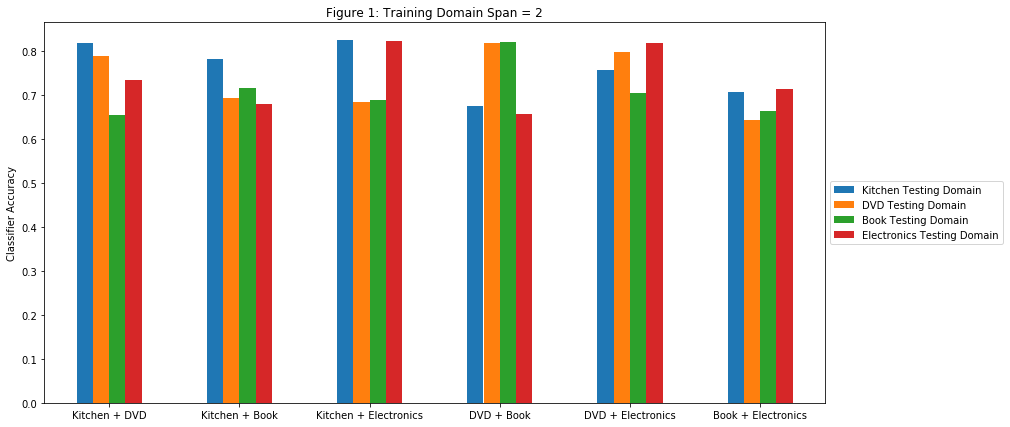

,Kitchen Testing Domain,DVD Testing Domain,Book Testing Domain,Electronics Testing Domain
Kitchen + DVD + Book,0.7900,0.7933,0.8000,0.7217
Kitchen + DVD + Electronics,0.7983,0.7767,0.7150,0.8000
Electronics + DVD + Book,0.7600,0.7883,0.7967,0.7733
Kitchen + Book + Electronics,0.7817,0.6917,0.7517,0.7583


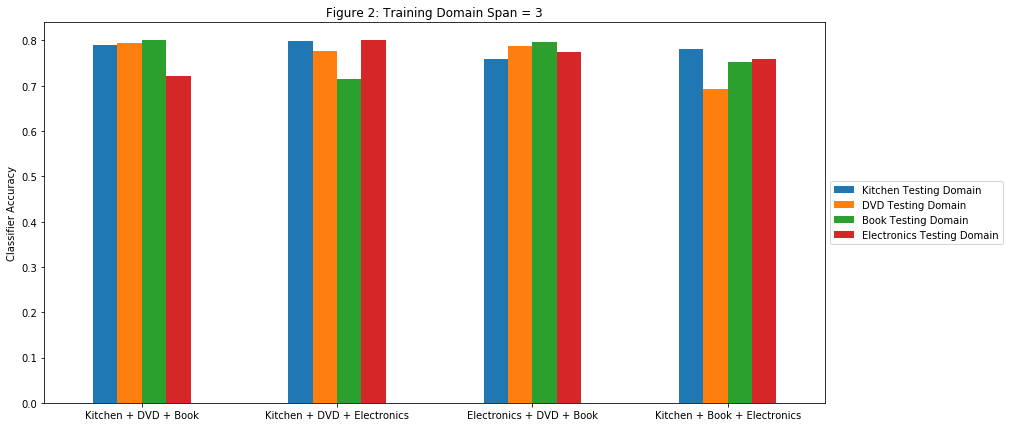

,Kitchen Testing Domain,DVD Testing Domain,Book Testing Domain,Electronics Testing Domain
Kitchen + DVD + Book + Electronics,0.8133,0.7717,0.785,0.7683


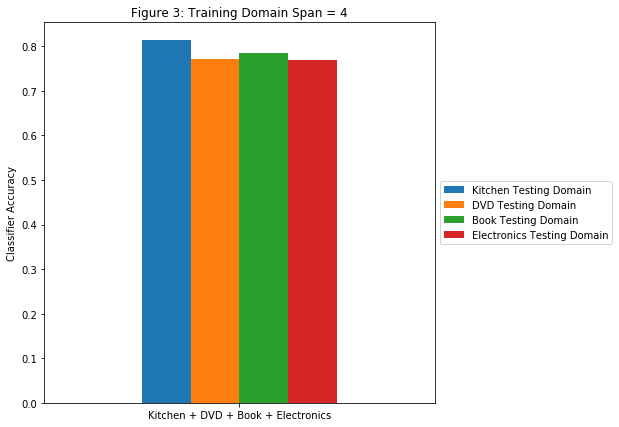

In [150]:
#Separate results by training data domain span
DoubleSource = {
        "Kitchen Testing Domain":allAccuracies[0][0],
        "DVD Testing Domain":allAccuracies[1][0],
        "Book Testing Domain":allAccuracies[2][0],
        "Electronics Testing Domain":allAccuracies[3][0]}
TripleSource = {
        "Kitchen Testing Domain":allAccuracies[0][1],
        "DVD Testing Domain":allAccuracies[1][1],
        "Book Testing Domain":allAccuracies[2][1],
        "Electronics Testing Domain":allAccuracies[3][1]}
QuadSource = {
        "Kitchen Testing Domain":allAccuracies[0][2],
        "DVD Testing Domain":allAccuracies[1][2],
        "Book Testing Domain":allAccuracies[2][2],
        "Electronics Testing Domain":allAccuracies[3][2]}


#Create pandas dataframe and bar chart for each
df = pd.DataFrame(DoubleSource)
df.index = ('Kitchen + DVD','Kitchen + Book','Kitchen + Electronics','DVD + Book', 'DVD + Electronics','Book + Electronics')
display(df)
df.plot(kind='bar', stacked=False, rot=0, figsize=(14,7), zorder=5, title=("Figure 1: Training Domain Span = 2"))
plt.ylabel("Classifier Accuracy")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

df = pd.DataFrame(TripleSource)
df.index = ('Kitchen + DVD + Book','Kitchen + DVD + Electronics','Electronics + DVD + Book', 'Kitchen + Book + Electronics')
display(df)
df.plot(kind='bar', stacked=False, rot=0, figsize=(14,7), zorder=5, title=("Figure 2: Training Domain Span = 3"))
plt.ylabel("Classifier Accuracy")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

df = pd.DataFrame(QuadSource)
df.index = ['Kitchen + DVD + Book + Electronics']
display(df)
df.plot(kind='bar', stacked=False, rot=0, figsize=(7,7), zorder=5, title=("Figure 3: Training Domain Span = 4"))
plt.ylabel("Classifier Accuracy")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


In figure 1 we can see the two 'couplings' so to speak within the training domains, there exists a clear overlap between the kitchen and electronics categories, as well as between those of book and DVD. In all cases in which the training data included either both, or neither categories of the pair, both performed to very similar degrees. I commented on this relationship between kitchen and electronics in section 2b, however figure 1 illustrates the one between book and DVD much more vividly. The reason for this is because books and DVD's can be seen to simply be two different mediums to portray the same thing (such as a fictional story), and so there is much overlap in the vocabulary used to describe them.

As you would expect in figure 3, the test domain that was not included in the training data was the worst performing in all instances whilst there was no great discrepancy between the performance of the other 3. This drop was least significant for the kitchen domain, which gives justification for it being the strongest performer in figure 3. When all domains are used for training data, the performances of each test domain largely averages out, as each has had roughly the same amount of relevant training data. 

## Question 3: Document Similarity (25 marks)
The objective of this question is to investigate whether incorporating lexical knowledge from WordNet might improve document similarity methods.  For example, knowing that both *tiger* and *leopard* are hyponyms of *big_cat* should increase the similarity between a document mentioning a *tiger* and a document mentioning a *leopard*.

The code below will generate two document collections, both in bag-of-words format, one from the Medline Corpus and one from the Wall Street Journal corpus.

In this question, there are marks available for the quality of your code and the quality of your explanations.

In [293]:
from sussex_nltk.corpus_readers import MedlineCorpusReader
from sussex_nltk.corpus_readers import WSJCorpusReader
from nltk.stem.wordnet import WordNetLemmatizer

def normalise(tokenlist):
    """
    Reduces everything to lower case, replacing digits and decimals with NUM, and positional descriptors with Nth
    Params: tokenlist - a list of un-normalised tokens
    Return: tokenlist - a normalised version of the input
    """
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

def filter_stopwords(tokenlist):
    """
    Removes the most common words in the english language
    Params: tokenlist - a list of string tokens
    Returns: revised tokenlist with no stopwords (e.g "to", "the", "and")
    """
    stop = stopwords.words('english')
    return [w for w in tokenlist if w.isalpha() and w not in stop]

def stem(tokenlist):
    """
    Reduces words to their lemma (e.g running -> run)
    Params: tokenlist - list of tokens
    Returns: tokenlist - every token now the lemma of its former self
    """
    st=WordNetLemmatizer()
    return [st.lemmatize(token) for token in tokenlist]

   
def make_bow(somestring):
    """
    Converts a string representation to a bag-of-words representation
    Params: somestring - document stored as a string
    Returns: dict_rep - the same document represented by a bag-of-words dictionary
    """
    rep=word_tokenize(somestring)  #step 1
    rep=normalise(rep)   #step 2
    rep=stem(rep)   #step 3
    rep=filter_stopwords(rep)  #step 4
    dict_rep={}
    for token in rep:
        dict_rep[token]=dict_rep.get(token,0)+1  #step 5
    return(dict_rep)

wsj=WSJCorpusReader()
medline=MedlineCorpusReader()

collectionsize=50
collections={"wsj":[],"medline":[]}

for key in collections.keys():
    if key=="wsj":
        generator=wsj.raw()
    else:
        generator=medline.raw()
    while len(collections[key])<collectionsize:
        collections[key].append(next(generator))

bow_collections={key:[make_bow(doc) for doc in collection] for key,collection in collections.items()}

a). For each step in the `make_bow()` function, **explain** what it does and why it is applicable when creating document representations for document similarity methods. \[8 marks\]

**Step 1**

The first step involves the tokenization of the string that is passed to the function `word_tokenize`, the result of which is stored in the variable `rep`. Tokenization involves the separating of a sentence (usually by whitespace) in to its individual words, storing them within a list as opposed to the entirety as one string. This is necessary when creating a document representation as it is a precurser for many other types of preprocessing. In the context of document similarity, two sentences may contain many of the same words, but be deemed unrelated by a computer if they're in a different order, as it won't be able to equate the two strings. Much more success, and therefore accuracy, will be had when comparing what tokens two documents share, as opposed to what sentences. 

e.g `"Hello world" = ["Hello", "world"]`

**Step 2**

Every token within `rep` is normalised. The normalization involves converting every character to lower case, replacing every number or decimal with "NUM", any description of position with "Nth". This can greatly reduce the amount of unique tokens by abstracting information that is not relevant for similarity comparison. Without this, "Leopard" and "leopard" for example, would be deemed different words, skewing similarity scores and increasing run-time.

**Step 3**

Morphological variants of words that we would not wish to distinguish account for a significant amount of the lexical variation within a document. This step lemmatizes the contents of `rep`, meaning all morphological variants are replaced with their root word, its lemma. E.g "walking" would be replaced by "walk". The reduced vocabulary size greatly improves run times and leads to more accurate similarity scores.

**Step 4**

The contents of `rep` are now passed in to the `filter_stopwords` function and then updated with what is returned. Stop words include those such as "to", "the" or "it", they are very high-frequency and low-information words. Removing them greatly refines the bag-of-words representation to contain only the more significant words, resulting in drastically reduced runtimes, and preventing similarity scores from being inflated by the inclusion of the most common words in the english lexicon. Punctuation is also removed here as it doesn't satisfy the `.isalpha()` condition.

**Step 5**

This loop iterates through every token within `rep`, populating a dictionary with each token as a key. The corresponding value to each is incremented by one with each occurence of that key, resulting in a dicionary mapping unique tokens to its frequency within the document.

b). Apply a TF-IDF weighting to the representations and then compute: 
* the average cosine similarity of medline documents to each other, 
* the average cosine similarity of WSJ documents to each other,
* the average cosine similarity of medline documents to WSJ documents
\[8 marks\]

In [294]:
import math
from statistics import mean


def dot(docA,docB):
    """
    Takes two documents and calculates their dot product (taken from lab_4_2 solutions)
    Params: docA, docB - two documents, represented as dictionaries
    Returns: the_sum - the dot product of docA and docB
    """
    the_sum=0
    for (key,value) in docA.items():
        the_sum+=value*docB.get(key,0)
    return the_sum


def cos_sim(docA,docB):
    """
    Calculates the cosine similarity of two documents (from lab_4_2 solutions)
    Params: docA, docB - two documents, represented as dictionaries
    Returns: sim - the cosine similarity of docA and docB
    """
    sim=dot(docA,docB)/(math.sqrt(dot(docA,docA)*dot(docB,docB)))
    return sim


def idf(doclist):
    """
    Calculates the idf values for the features of a list of documents (from lab_4_2 solutions)
    Params: doclist - a list of documents
    Returns: dictionary of idf values
    """
    N=len(doclist)
    return {feat:math.log(N/v) for feat,v in doc_freq(doclist).items()}


def doc_freq(doclist):
    """
    Creates a dictionary mapping all tokens to their frequency within a corpus
    Params: doclist - a list of documents, each represented as a dictionary
    Return: df - a doctionary mapping tokens (as keys) to their respective frequencies (values)
    """
    df={}
    for doc in doclist:
        for feat in doc.keys():
            df[feat]=df.get(feat,0)+1 #Looks up token as key, iterating associated value by 1 if found
    return df


def tf_idf(doclist, idf):
    """
    Calculates 'Term frequency - inverse document frequency' of each word, giving more weight to uncommon words that appear in different docs
    Params: doclist - a list of documents represented as dictionaries in the format {token:frequency}
            idf - a dictionary of idf values
    Return: tfidf_weights - a list of documents, where each document is a dictionary mapping tokens to tf_idf weights
    """
    tfidf_weights = []
    for doc in doclist:
        document = {}
        for key, value in doc.items():
            document[key] = idf[key] * value #calculates tf-idf for each word using idf value and frequency
        tfidf_weights.append(document)
    return tfidf_weights


def average_cos_sim(docListA, docListB):
    """
    Computes the average cosing similarity between two given corpora
    Params: docListA, docListB - lists of dictionaries, with each dictionary representing a document
    Returns: the average cosine similarity between docListA and docListB
    """
    cos_values = []
    for docA in docListA:
        for docB in docListB:
            cos_values.append(cos_sim(docA, docB))
    return mean(cos_values)


#Calculates tf-idf for medline and wsj
medline_idf = idf(bow_collections['medline'])
wsj_idf = idf(bow_collections['wsj'])
medline_tfidf = tf_idf(bow_collections['medline'],medline_idf)
wsj_tfidf = tf_idf(bow_collections['wsj'],wsj_idf)


print("The average cosine similarity of Medline docuemnts to each other:",average_cos_sim(medline_tfidf,medline_tfidf))
print("The average cosine similarity of WSJ documents to each other:",average_cos_sim(wsj_tfidf,wsj_tfidf))
print("The average cosine similarity of Medline documents to WSJ documents:",average_cos_sim(medline_tfidf,wsj_tfidf))

The average cosine similarity of Medline docuemnts to each other: 0.04253294742509128
The average cosine similarity of WSJ documents to each other: 0.042765676237362896
The average cosine similarity of Medline documents to WSJ documents: 0.007115179228025695


The cosine similarity of 2 documents $A$ and $B$ can be described as:

\begin{eqnarray*}
\mbox{sim}_{\mbox{cosine}}(A,B) = \frac{A.B}{\sqrt{A.A \times B.B}}
\end{eqnarray*}

The dot product of those documents is given by:

\begin{eqnarray*}
A.B = \sum_{\mbox{f}} \mbox{tf-idf weight}(A,f)\times \mbox{tf-idf weight}(B,f) 
\end{eqnarray*}


The purpose of the tf-idf weight is to add more percieved similarity if 2 documents share a rare word, rather than a common one.

c). Expand the document representations by adding **synonyms** and **hypernyms** for each **noun** in the document.  For example, 2 occurrences of the word *tiger* should add 2 occurrences of each of the following **lemma_names** found in the WordNet hypernym hierarchy above *tiger*:
* \['tiger', 'Panthera_tigris'\]
* \['big_cat', 'cat'\]
* \['feline', 'felid'\]
* \['carnivore'\]
* \['placental', 'placental_mammal', 'eutherian', 'eutherian_mammal'\]
* \['mammal', 'mammalian'\]
* \['vertebrate', 'craniate'\]
* \['chordate'\]
* \['animal', 'animate_being', 'beast', 'brute', 'creature', 'fauna'\]
* \['organism', 'being'\]
* \['living_thing', 'animate_thing'\]
* \['whole', 'unit'\]
* \['object', 'physical_object'\]
* \['physical_entity'\]
* \['entity'\]

Recompute the similarities calculated in part b).  Discuss your results. \[9 marks\]

In [295]:
def distance_to_root(asynset, allHypernyms):
    """
    Adapted from lab_5_1 solutions, recursive function to retrieve all the hypernyms of a given synset by climbing 
    the hierachy until reaching the root.
    Params: asynset - synset of which you want to find all the hypernyms
            allHypernyms - the list of all found hypernyms (of asynset) so far
    Return: allHypernyms - the completed list of all hypernyms to a given synset
    """
    hypernyms = asynset.hypernyms()
    for hypernym in hypernyms:
        allHypernyms.append(hypernym.lemma_names())
    if len(hypernyms)==0:
        #reached the top and have to stop
        return 0
    else:
        #if len(hypernyms)>1:
            #print("Warning: multiple hypernyms")
        return (distance_to_root(hypernyms[0], allHypernyms)+1)

Conceptually the code below is very simple. Check every word, if it's a noun retrieve all synonyms, use the above recursive call on each to retrieve all hypernyms. Add them all to the bag-of-words.

In [298]:
def addHypernyms(docList, allHypernyms):
    """
    A function to update the document list to include all synonyms and hypernyms of every noun present.
    Params: docList - list of documents, each one represented by a dictionary
            allHypernyms - empty list to be populated by all hypernyms to a synset
    """
    updatedDocList = []
    
    for doc in docList: #For each documet
        updatedDoc = doc.copy() 
        for key, val in doc.items(): #For each word
            if key in nouns:
                for synset in wordnet.synsets(key): #For every synonym
                    distance_to_root(synset, allHypernyms) #Recursive call to find hypernyms
                    #This nested loop unpacks all the stored hypernyms and tallies them up
                    for hypernymList in allHypernyms:
                        for hypernym in hypernymList:
                            #This line satisfies the requirement that 2 occurences of 'tiger' must add 2 of each hypernym
                            updatedDoc[hypernym] = updatedDoc.get(hypernym, 0)+1    
                    allHypernyms = []
        updatedDocList.append(updatedDoc)
    return updatedDocList

In [299]:
from nltk.corpus import wordnet
allHypernyms = []   
nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')}   
                  
medlineExpanded = addHypernyms(bow_collections['medline'], allHypernyms)
wsjExpanded = addHypernyms(bow_collections['wsj'], allHypernyms)

medline_tfidf = tf_idf(medlineExpanded, idf(medlineExpanded))
wsj_tfidf = tf_idf(wsjExpanded, idf(wsjExpanded))   

print("The average cosine similarity of Medline docuemnts to each other:",average_cos_sim(medline_tfidf,medline_tfidf))
print("The average cosine similarity of WSJ documents to each other:",average_cos_sim(wsj_tfidf,wsj_tfidf))
print("The average cosine similarity of Medline documents to WSJ documents:",average_cos_sim(medline_tfidf,wsj_tfidf))

The average cosine similarity of Medline docuemnts to each other: 0.09738599243803296
The average cosine similarity of WSJ documents to each other: 0.09961429128974011
The average cosine similarity of Medline documents to WSJ documents: 0.05715982158124834


As one would expect, the cosine similarities increased in all comparisons once we expanded each documents bag-of-words representation to include all hypernyms and synonyms for each noun. Adding all of these extra words could only result in more commonalities between any two given documents, and so I feel this result was inevitable, the degrees to which each increased however is certainly intersting. The cosine similarities of the Medline and WSJ documents increased by **128%** and **132%** respectively (to 3 s.f), whilst the result of the Medline to WSJ comparison now sits at **803%** of what it was before the synonym and hypernym addition. Although this last comparison saw a significantly greater increase, it must be noted that the similarity is still much less than that of the other two, sitting at a little over half (55.6%) of the average of the other two.

I suspect that the reason for this huge difference in improvement between the comparisons lies within the lexicons of each document set. One would assume that documents from the same corpus to already have more overlap within their lexicons, leaving less space for improvement once all synonyms and hypernyms are included. My findings here are in support of this hypothesis.

## Question 4: Supervised Methods for WSD (25 marks)
The objective of this question is to build and evaluate a word sense disambiguation (WSD) system for words with multiple senses.  

a).  For each word occurring in the medline corpus (defined above), **write code** to find how many senses it has according to WordNet.  Print a list of the 10 most frequently occurring words with 2 senses (in this corpus). \[4 marks\]

In [7]:
from nltk.corpus import wordnet as wordnet
 
words = doc_freq(bow_collections['medline'])
sortedWords = sorted(words.items(), key = lambda kv: kv[1])
results = {}
i = len(sortedWords)-1

#Loop until the top 10 have been found
while len(results) < 10:
    if len(wordnet.synsets(sortedWords[i][0])) == 2: #Checks each word has exactly 2 senses
        results[sortedWords[i][0]] = sortedWords[i][1] #Adds to output if so
    i-=1
    
df = pd.DataFrame.from_dict(results, orient = 'index', columns = ["Frequency"])
display(df)

,Frequency
membrane,10
molecular,7
temperature,7
molecule,6
data,6
uptake,6
phenomenon,5
amino,5
may,5
discussed,4


This looping structure iterates through a sorted list of the most common words, at each step checking if the word in question has exactly 2 senses. If it does it is appended to the output, and this loop terminates once the first 10 have been found, displaying the output in a pandas dataframe.

b). A *supervised* WSD algorithm derives model(s) from *sense-annotated corpus data* in order to predict senses of ambiguous words in un-annotated data.  Using the entire document as context, **implement** a supervised word sense disambiguation algorithm to determine the most likely sense of each occurrence of the 3 most frequently occuring words identified in part a). \[8 marks\]

In [163]:
from nltk.classify.naivebayes import NaiveBayesClassifier
from nltk.corpus import semcor

allfiles=semcor.fileids() #list of fileids
random.seed(candidateno)
shuffled=list(allfiles)
random.shuffle(shuffled)

word1="membrane"
word2="molecular"
word3="temperature"

In [164]:
medline=MedlineCorpusReader()

collectionsize=1000
collections={"medline":[]}

for key in collections.keys():
    generator=medline.raw()
    while len(collections[key])<collectionsize:
        collections[key].append(next(generator))

bow_collections={key:[make_bow(doc) for doc in collection] for key,collection in collections.items()}

The above code creates a new bag-of-words representation of the medline corpus, this time of size 1000 as opposed to 50 that has been used until now. The purpose of this is to have a much greater amount of data which we can then slice in to training and testing sets.

In [301]:
"""
Please note that these methods have been taken from lab slolutions to lab_6_1
"""

def extract_tags(taggedsentence):
    '''
    For a tagged sentence in SemCor, identify single words which have been tagged with a WN synset
    taggedsentence: a list of items, some of which are of type wordnet.tree.Tree
    :return: a list of pairs, (word,synset)
    
    '''
    alist=[]
    for item in taggedsentence:
        if isinstance(item,nltk.tree.Tree):   #check with this is a Tree
            if isinstance(item.label(),nltk.corpus.reader.wordnet.Lemma) and len(item.leaves())==1:
                #check whether the tree's label is Lemma and whether the tree has a single leaf
                #if so add the pair (lowercased leaf,synsetlabel) to output list
                alist.append((item.leaves()[0].lower(),item.label().synset()))
    return alist           

def extract_senses(fileid_list):
    '''
    apply extract_tags to all sentences in all documents in a list of file ids
    fileid_list: list of ids
    :return: list of list of (token,tag) pairs, one for each sentence in corpus
    '''
    sentences=[]
    for fileid in fileid_list:
        print("Processing {}".format(fileid))
        sentences+=[extract_tags(taggedsentence) for taggedsentence in semcor.tagged_sents(fileid,tag='sem')]
    return sentences

def contains(sentence,astring):
    '''
    check whether sentence contains astring
    '''
    if len(sentence)>0:
        tokens,tags=zip(*sentence)
        return astring in tokens
    else:
        return False
    
def get_label(sentence,word):
    '''
    get the synset label for the word in this sentence
    '''
    count=0
    label="none"
    for token,tag in sentence:
        if token==word:
            count+=1
            label=str(tag)
    if count !=1:
        #print("Warning: {} occurs {} times in {}".format(word,count,sentence))
        pass
    return label
    
def get_word_data(training_sentences,word):
    '''
    select sentences containing words and construct labelled data set where each sentence is represented using Bernouilli event model
    '''
    selected_sentences=[sentence for sentence in training_sentences if contains(sentence,word)]
    word_data=[({token:True for (token,tag) in sentence},get_label(sentence,word)) for sentence in selected_sentences] 
    return word_data

In [249]:
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn


def convertToListOfStrings(documents):
    """
    This function performs a critical step in converting our medline bag-of-words to match the format of SemCor
    Params: documents - a document stored as a dictionary
    Return: stringDocs - the same document reformatted as a list of strings
    """
    stringDocs = []
    for doc in documents: #Iterates through each document
        my_string = "" #Initialise empty string to represent each doc
        for (word,val) in doc.items(): #add each word to a string followed by a whitespace
            my_string += word
            my_string += " "
        stringDocs.append(my_string) #Append each string to list
    return stringDocs 

def preProcessTokenList(somestring):
    """
    Critically this performs tokenisation, which is needed to convert get our string representation 1 step closer to that of SemCor
    Params: somestring - A string representing a single sentence within the output of convertToListOfStrings
    Returns: rep - the same sentence tokenised, normalised, stemmed, with stop words removed
    """
    rep=word_tokenize(somestring)  #step 1
    rep=normalise(rep)   #step 2
    rep=stem(rep)   #step 3
    rep=filter_stopwords(rep)
    return rep

#Converts our bag-of-words in to a list of sentences stored as strings
medline = convertToListOfStrings(bow_collections['medline'])

#Tokenizes (along with other basic pre-processing) each sentence within medline
tokenListOfLists = []     
for i in range(len(medline)):
    tokenListOfLists.append(preProcessTokenList(medline[i]))    

#Uses nltk.lesk to add labels and convert data in to the exact same form as SemCor for use in our classifiers
medlineLesk = []
sentenceIndex = 0
for sentence in tokenListOfLists:#Iterates through every sentence
    tupleList = []
    for word in sentence:#For each word within sentence
        leskTuple = (word, lesk(sentence, word))#Creates a tuple in the format (word, synset)
        tupleList.append(leskTuple) #Appends to a list of tuples, representing 1 sentence
    medlineLesk.append(tupleList)#Adds each sentence lists to super-list
    sentenceIndex +=1

    
    
#Separate data in to training (70%) and testing (30%)
medlineTrainingSents = medlineLesk[300:]
medlineTestingSents = medlineLesk[:300]
    
#print(medlineLesk)

The purpose of the above code is to reformat our medline texts to mirror those of the SemCor, allowing us to them with our classifiers. It makes use of NLTK.Lesk to retrieve the labels - given a word and its context, Lesk returns the synset with the highest number of overlapping words between the context sentence and different definitions from each synset. 

In [257]:
def evaluate(cls,test_data):    
    correct=0    
    wrong=0    
    predictions={}    
    actual={}    
    for doc,label in test_data:
        prediction=cls.classify(doc)        
        predictions[prediction]=predictions.get(prediction,0)+1        
        actual[label]=actual.get(label,0)+1        
        if prediction==label:
            correct+=1        
        else:            
            wrong+=1    
    acc=correct/(correct+wrong)
    #print("Preds: ", predictions)
    #print("Actual: ", actual)
    print(" {} out of {}".format(correct,correct+wrong), " = ", round(acc*100,2),"%")
    
    
    
def train_and_test(word):
    training=get_word_data(medlineTrainingSents,word)    
    testing=get_word_data(medlineTestingSents,word)
    
    classifier=NaiveBayesClassifier.train(training)    
    evaluate(classifier,testing)    

In [258]:
print("Correct disambiguations of ", word1,":")
train_and_test(word1)
print("Correct disambiguations of ", word2,":")
train_and_test(word2)
print("Correct disambiguations of ", word3,":")
train_and_test(word3)

Correct disambiguations of  membrane :
 3 out of 27  =  11.11 %
Correct disambiguations of  molecular :
 20 out of 22  =  90.91 %
Correct disambiguations of  temperature :
 10 out of 19  =  52.63 %


c). Evaluate the performance of your WSD system.  How accurate is it for each of the 3 words? **Comment** on the strengths and weaknesses of your WSD system.\[8 marks\] 

First let us break down the above results in to a confusion matrix for each of the 3 words. As we have established, each word has two possible ambiguations, one of which is labelled `.01` and the other `.02` within its synset, this is the heuristic upon which the matricies are based.


<b><center>membrane</center></b>

|-----| Predicted `.01`   | predicted `.02`   |
|------|------|------|
| **Actual** `0.1`  | 3 True Positive |0 False Negative|
|**Actual** `0.2`|24 False Positive |0 True Negative|

<b><center>molecular</center></b>

|-----| Predicted `.02`   | predicted `.01`   |
|------|------|------|
| **Actual** `0.1`  | 20 True Positive |0 False Negative|
|**Actual** `0.2`|2 False Positive |0 True Negative|

<b><center>temperature</center></b>

|-----| Predicted `.01`   | predicted `.02`   |
|------|------|------|
| **Actual** `0.1`  | 9 True Positive |0 False Negative|
|**Actual** `0.2`|3 False Positive |7 True Negative|

From this we are able to calculate the metrics below. Since it is arbitrary which sense of a word we class as positive or negative, I have reversed them for molecular as to not get null values for precision, recall and F1-score.

|-----| membrane   | molecular   | temperature |
|------|------|------|-----|
| **Accuracy**  | 0.111 | 0.909 | 0.526 |
|**Precision** | 0.111 | 0.909 | 0.75 |
|**Recall** | 1 | 1 | 1 |
|**F1-Score** | 0.199 | 0.18 | 0.857 |

The first interesting point of observation is that in the cases of `molecular` and `membrane`, the classifiers only ever predicted the words to mean one sense of the word, causing a great imbalance between precision and recall, and resultantly a reduced F1-score. It is of course very possible that this is in fact the case, considering the alternative definitions may bear no relationship to the scientific lexicon of these papers. However I decided to investigate the prior probabilities along with the different definitions in the hope of confirming this. The code below iterates through every label in the entirety of the labelled medline training data and counts the total occurences of each sense of our 3 words. The following cell produces the associated definitions for each meaning of these words.

In [266]:
labels={}
for doc,label in get_word_data(medlineLesk[300:], 'membrane'):
     labels[label]=labels.get(label,0)+1
print(labels)
labels={}
for doc,label in get_word_data(medlineLesk[300:], 'molecular'):
     labels[label]=labels.get(label,0)+1
print(labels)
labels={}
for doc,label in get_word_data(medlineLesk[300:], 'temperature'):
     labels[label]=labels.get(label,0)+1
print(labels)

{"Synset('membrane.n.02')": 34, "Synset('membrane.n.01')": 3}
{"Synset('molecular.a.02')": 16}
{"Synset('temperature.n.02')": 10, "Synset('temperature.n.01')": 10}


In [264]:
print("All wordnet definitions of our 3 ambiguous words: ")

for ss in wn.synsets('membrane'):
    print(ss, ss.definition())
for ss in wn.synsets('molecular'):
    print(ss, ss.definition())
for ss in wn.synsets('temperature'):
    print(ss, ss.definition())

All wordnet definitions of our 3 ambiguous words: 
Synset('membrane.n.01') a thin pliable sheet of material
Synset('membrane.n.02') a pliable sheet of tissue that covers or lines or connects the organs or cells of animals or plants
Synset('molecular.a.01') relating to or produced by or consisting of molecules
Synset('molecular.a.02') relating to simple or elementary organization
Synset('temperature.n.01') the degree of hotness or coldness of a body or environment (corresponding to its molecular activity)
Synset('temperature.n.02') the somatic sensation of cold or heat


As you can see, there are clear imbalances in the labels within the training data for `membrane` and `molecular`. This will cause extreme prior probabilites leading to the very imbalanced results we have. When I cross-check the associated definitions, the imbalance within `membrane`'s labels seems completely justified - I find much more likely that within Medline, the word 'membrane' is used to refer to tissue connecting organs or cells as opposed to a pliable sheet of material. In the case of `molecular` however, the alternative definition to that which you would expect seems to be by far and beyond the most prevalent. This leads me to what I believe to be the greatest weakness of this WSD system - NLTK.Lesk, the package with which all the data (training + testing) was labelled. From both my personal experience as well as my research, it seems to be a fairly notoriously unreliable heuristic, and I regard this to be the cause for the apparent overwhelming presence of the non-scientific definition of `molecular`. 

One great redeeming factor of the system however, is that fact that NLTK.Lesk was used to label all of the data, training as well as testing, meaning that in terms of its metrics, it could be seen to be irrelevant if the words are associated with the wrong definitions, so long as it is done consistently across both data sets. This is why we see the very high accuracy, precision and recall for `molecular`, as it is simply checking for matches beween predictions and labels, without cross-checking the definitions to ones decided by a (more intelligent) third party.

d) How could you extend or improve your WSD system?  You are **not** expected to code any of these extensions or improvements, but your answer should give sufficient details to make it clear how they might be carried out in practice. \[5 marks\]

**Hand-labelled data** - As outlined above, one clear limiting factor is the questionable reliability of all labels. For the purpose of this assignemt it would not have been practical to do so myself considering the quantity of data used, however I do anticipate this would be very beneficial to the systems legitimacy.

**Smoothing** - Since not all definitions were found in the training data, this made it impossible for one definition of `molecular` to be classified correctly should it ever appear in any testing data. The implementation of laplace / add-one smoothing would be a suitable countermeasure here, this is done simply by adding 1 to the frequency of all labels that could be found in the training data.

**More training data** - As we learned in section 2a, more training data can be very beneficial to models such as this. I would also like to investigate the inclusion of comparitively small amounts of more varied training data, to allow the model to see examples of all definitions and the contexts in which they may appear, without skewing prior probabilities too much.

**Data format** - Although much work went in to the specific formatting of the data used, I worry that certain information that may have been lost during its transformation from a bag-of-words could have proven beneficial. Unlike with sentiment analysis, grammar and context are important with WSD, as it is attempting to deduce the meaning of a word based on what words it is used in conjunction with.


Use the code below to verify that the length of your submission does not exceed 3000 words.

In [300]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 1202

import io
from nbformat import current

filepath="a1.ipynb"
question_count=1208

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 3998
